# Variant Prioritisation
- BP GWAS data from Evangelou et al. annotated in Hail and from a few external sources (GTEx, DeepSEA, and UCSC genome browser)
- GWAS summary statistics including all 3 phenotype betas (sbp, dbp and pp)
- Positive-unlabelled machine learning applied
    - Curating positive variants via variants pathogenic for cardiovascuar diseases in ClinVar from collated BP GWAS'  
- Evangelou et al. variants found to be significant and in high LD prioritised (approx. 42,000 variants)

    ## Methods tested:
    - XGBoost vs Light GBM
    - PUlearn package vs 'from scratch' positive-unlabelled learning code
    - Replacing heavily missing features' NaNs with zero values (and only imputing <25% complete features vs using only <25% complete features vs using XGB with missing values

## Code Sections:
1. Replacing NaNs with zero values
2. Using only <25% complete features
3. Using the missing values

In [1]:
#import libraries:

import pandas as pd
import numpy as np
import time
import re
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import lightgbm as lgb
from pulearn import ElkanotoPuClassifier
from pulearn import WeightedElkanotoPuClassifier
from pulearn import BaggingPuClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay

import shap
import warnings
warnings.filterwarnings('ignore')


seed = 42

In [2]:
pd_table = pd.read_csv('BP_GWAS_data.csv')
pd_table = pd_table.drop(['BETAmean'], axis=1)

In [3]:
features = pd_table.drop(['Gene', 'CP', 'label'], axis=1)

In [4]:
features = features[['CADD.raw_score',
 'CADD.PHRED_score',
 'BETAsbp',
 'BETAdbp',
 'BETApp',
 'minP',
 'polyphen_score',
 'sift_score',
 'motif_score_change',
 'REVEL',
 'MVP',
 'GenoCanyon',
 'DEOGEN2',
 'integrated_fitCons',
 'LINSIGHT',
 'SiPhy_29way_logOdds',
 'bStatistic',
 'H3k9ac_signalValue',
 'H3k4me1_signalValue',
 'H3k4me2_signalValue',
 'H3k4me3_signalValue',
 'H4k20me1_signalValue',
 'H3k79me2_signalValue',
 'H3k27me3_signalValue',
 'H3k27ac_signalValue',
 'H3k36me3_signalValue',
 'H3k9me3_signalValue']]

## Remove correlating features

In [5]:
features['label'] = np.where(pd_table['label'] == True, 1, 0)
correlated_features = set()
correlation_matrix = features.corr()

In [6]:
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [7]:
print(correlated_features)

{'CADD.PHRED_score'}


In [8]:
list(features)

['CADD.raw_score',
 'CADD.PHRED_score',
 'BETAsbp',
 'BETAdbp',
 'BETApp',
 'minP',
 'polyphen_score',
 'sift_score',
 'motif_score_change',
 'REVEL',
 'MVP',
 'GenoCanyon',
 'DEOGEN2',
 'integrated_fitCons',
 'LINSIGHT',
 'SiPhy_29way_logOdds',
 'bStatistic',
 'H3k9ac_signalValue',
 'H3k4me1_signalValue',
 'H3k4me2_signalValue',
 'H3k4me3_signalValue',
 'H4k20me1_signalValue',
 'H3k79me2_signalValue',
 'H3k27me3_signalValue',
 'H3k27ac_signalValue',
 'H3k36me3_signalValue',
 'H3k9me3_signalValue',
 'label']

## 1. Replace NaNs with zeros for features that are > 25% missing
- Hail annotations already complete, so only needed for external annotations

In [9]:
dt = pd_table[['CADD.raw_score',
 'CADD.PHRED_score',
 'BETAsbp',
 'BETAdbp',
 'BETApp',
 'minP',
 'polyphen_score',
 'sift_score',
 'motif_score_change',
 'REVEL',
 'MVP',
 'GenoCanyon',
 'DEOGEN2',
 'integrated_fitCons',
 'LINSIGHT',
 'SiPhy_29way_logOdds',
 'bStatistic',
 'H3k9ac_signalValue',
 'H3k4me1_signalValue',
 'H3k4me2_signalValue',
 'H3k4me3_signalValue',
 'H4k20me1_signalValue',
 'H3k79me2_signalValue',
 'H3k27me3_signalValue',
 'H3k27ac_signalValue',
 'H3k36me3_signalValue',
 'H3k9me3_signalValue']].fillna(value=0)

## Impute features that are < 25% missing
- Also removing correlated features previously identified and identifier columns

In [10]:
pd_table['Y'] = np.where(pd_table['label'] == True, 1, 0)
Y = pd_table['Y']
X = pd_table.drop(['label', 'Gene', 'CP', 'diagnosis', 'star', 'pathogenicity',
                   'Y'], axis=1)

X = dt

## PULearn Package Implementation:

### XGBoost Bagging

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [12]:
model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
pu_estimator = BaggingPuClassifier(
    base_estimator=model, n_estimators=15)
pu_estimator.fit(X_train, y_train)

y_pred = pu_estimator.predict_proba(X_test)

In [13]:
y_pred = y_pred[:,1]
y_predict = [1 if x > 0.5 else 0 for x in y_pred]
y_positive = y_test == 1

print('Classification results:')
acc = accuracy_score(y_positive, y_predict)
print("accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_positive, y_predict)
print("f1: %.2f%%" % (f1 * 100.0)) 
roc = roc_auc_score(y_positive, y_predict)
print("roc: %.2f%%" % (roc * 100.0)) 
rec = recall_score(y_positive, y_predict, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_positive, y_predict, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

bal = balanced_accuracy_score(y_positive, y_predict)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

Classification results:
accuracy: 99.96%
f1: 44.44%
roc: 66.66%
recall: 33.33%
precision: 66.67%
balanaced accuracy: 66.66%


### XGBoost Elkanoto:

In [14]:
estimator = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
pu_estimator = ElkanotoPuClassifier(estimator, hold_out_ratio=0.2)
pu_estimator.fit(X_train.values, y_train.values)

y_pred = pu_estimator.predict_proba(X_test.values)

In [15]:
y_predict = [1 if x > 0.5 else 0 for x in y_pred]
y_positive = y_test == 1

print('Classification results:')
acc = accuracy_score(y_positive, y_predict)
print("accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_positive, y_predict)
print("f1: %.2f%%" % (f1 * 100.0)) 
roc = roc_auc_score(y_positive, y_predict)
print("roc: %.2f%%" % (roc * 100.0)) 
rec = recall_score(y_positive, y_predict, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_positive, y_predict, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

bal = balanced_accuracy_score(y_positive, y_predict)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

Classification results:
accuracy: 99.95%
f1: 0.00%
roc: 50.00%
recall: 0.00%
precision: 0.00%
balanaced accuracy: 50.00%


## SHAP view of positives only in test data:

In [16]:
model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
pu_estimator = BaggingPuClassifier(
    base_estimator=model, n_estimators=15)
pu_estimator.fit(X_train, y_train)

y_pred = pu_estimator.predict_proba(X_test)

def estimator_predict(data_asarray):
    data_asframe = pd.DataFrame(data_asarray, columns=X_test.columns)
    return pu_estimator.predict(data_asframe)

In [17]:
X_pos_summary = shap.kmeans(X_test, 10)
ex = shap.KernelExplainer(estimator_predict, X_pos_summary)

In [18]:
X_test['Y'] = y_test
y_pos_test = X_test[X_test["Y"] == 1]
y_pos_test = y_pos_test.drop(['Y'], axis=1)
X_test = X_test.drop(['Y'], axis=1)
y_pos_test.shape

(6, 27)

  0%|          | 0/6 [00:00<?, ?it/s]

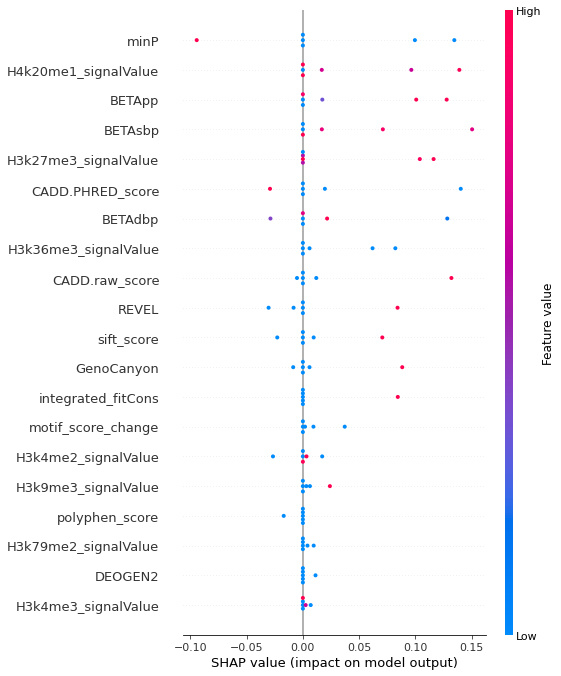

In [19]:
shap_values = ex.shap_values(y_pos_test)

fig, ax = plt.subplots()
shap.summary_plot(shap_values, y_pos_test)

In [20]:
expected_value = ex.expected_value

  0%|          | 0/6 [00:00<?, ?it/s]

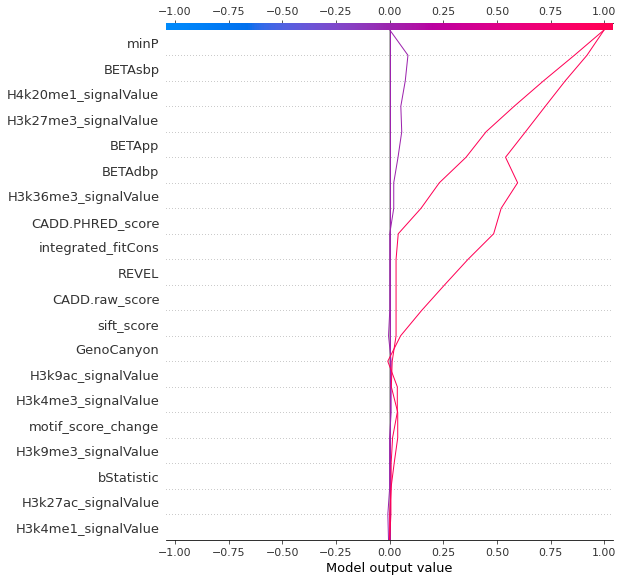

In [21]:
fig, ax = plt.subplots()
shap.decision_plot(
    expected_value,
    ex.shap_values(y_pos_test),
    list(y_pos_test),
    ignore_warnings=True,
)

## SHAP view of all 18 positives:

In [22]:
def estimator_predict(data_asarray):
    data_asframe = pd.DataFrame(data_asarray, columns=X_test.columns)
    return pu_estimator.predict(data_asframe)

X_pos_summary = shap.kmeans(X, 10)
ex = shap.KernelExplainer(estimator_predict, X_pos_summary)

In [23]:
X['Y'] = Y
y_pos = X[X["Y"] == 1]
y_pos = y_pos.drop(['Y'], axis=1)
X = X.drop(['Y'], axis=1)
y_pos.shape

(18, 27)

  0%|          | 0/18 [00:00<?, ?it/s]

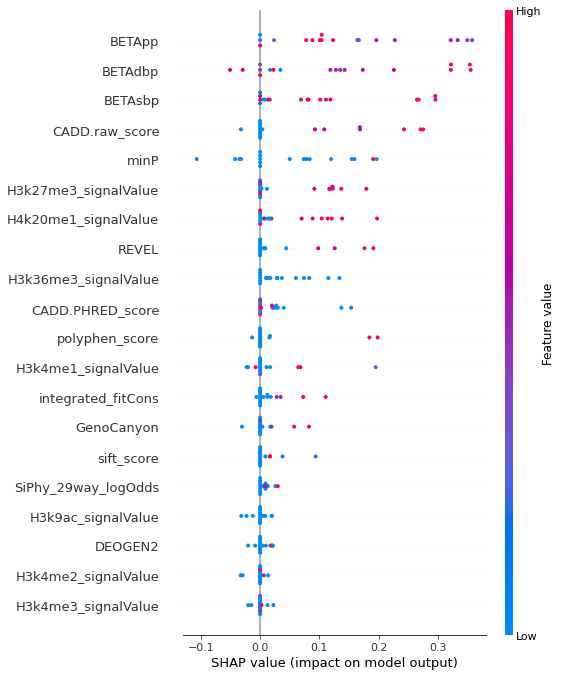

In [24]:
shap_values = ex.shap_values(y_pos)

fig, ax = plt.subplots()
shap.summary_plot(shap_values, y_pos)

In [25]:
expected_value = ex.expected_value

  0%|          | 0/18 [00:00<?, ?it/s]

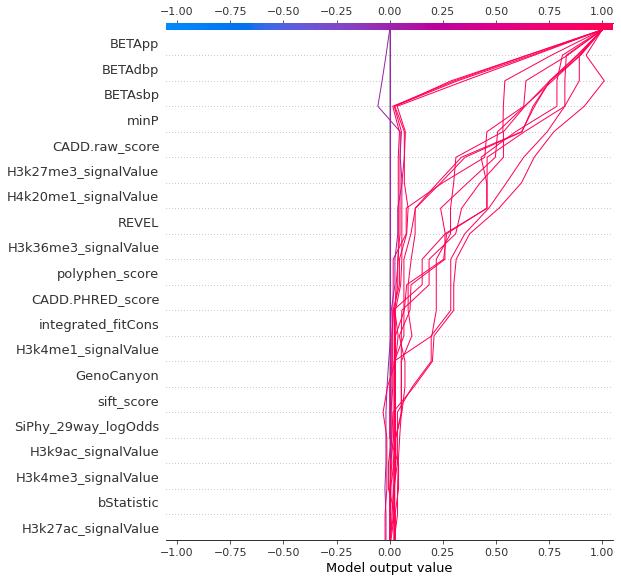

In [26]:
fig, ax = plt.subplots()
shap.decision_plot(
    expected_value,
    ex.shap_values(y_pos),
    list(y_pos),
    ignore_warnings=True,
)

### LightGBM:

In [27]:
model = lgb.LGBMClassifier(random_state=seed)
pu_estimator = BaggingPuClassifier(
    base_estimator=model, n_estimators=15)
pu_estimator.fit(X_train, y_train)

y_pred = pu_estimator.predict_proba(X_test)

In [28]:
y_pred = y_pred[:,1]
y_predict = [1 if x > 0.5 else 0 for x in y_pred]
y_positive = y_test == 1

print('Classification results:')
acc = accuracy_score(y_positive, y_predict)
print("accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_positive, y_predict)
print("f1: %.2f%%" % (f1 * 100.0)) 
roc = roc_auc_score(y_positive, y_predict)
print("roc: %.2f%%" % (roc * 100.0)) 
rec = recall_score(y_positive, y_predict, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_positive, y_predict, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

bal = balanced_accuracy_score(y_positive, y_predict)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

Classification results:
accuracy: 99.95%
f1: 0.00%
roc: 50.00%
recall: 0.00%
precision: 0.00%
balanaced accuracy: 50.00%


In [29]:
estimator = lgb.LGBMClassifier(random_state=seed)
pu_estimator = ElkanotoPuClassifier(estimator, hold_out_ratio=0.2)
pu_estimator.fit(X_train.values, y_train.values)

y_pred = pu_estimator.predict_proba(X_test.values)

In [30]:
y_predict = [1 if x > 0.5 else 0 for x in y_pred]
y_positive = y_test == 1

print('Classification results:')
acc = accuracy_score(y_positive, y_predict)
print("accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_positive, y_predict)
print("f1: %.2f%%" % (f1 * 100.0)) 
roc = roc_auc_score(y_positive, y_predict)
print("roc: %.2f%%" % (roc * 100.0)) 
rec = recall_score(y_positive, y_predict, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_positive, y_predict, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

bal = balanced_accuracy_score(y_positive, y_predict)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

Classification results:
accuracy: 97.71%
f1: 0.00%
roc: 48.88%
recall: 0.00%
precision: 0.00%
balanaced accuracy: 48.88%


In [31]:
def estimator_predict(data_asarray):
    data_asframe = pd.DataFrame(data_asarray, columns=X_test.columns)
    return pu_estimator.predict(data_asframe)

In [32]:
X_pos_summary = shap.kmeans(X_test, 10)
ex = shap.KernelExplainer(estimator_predict, X_pos_summary)

In [33]:
X_test['Y'] = y_test
y_pos_test = X_test[X_test["Y"] == 1]
y_pos_test = y_pos_test.drop(['Y'], axis=1)
X_test = X_test.drop(['Y'], axis=1)

  0%|          | 0/6 [00:00<?, ?it/s]

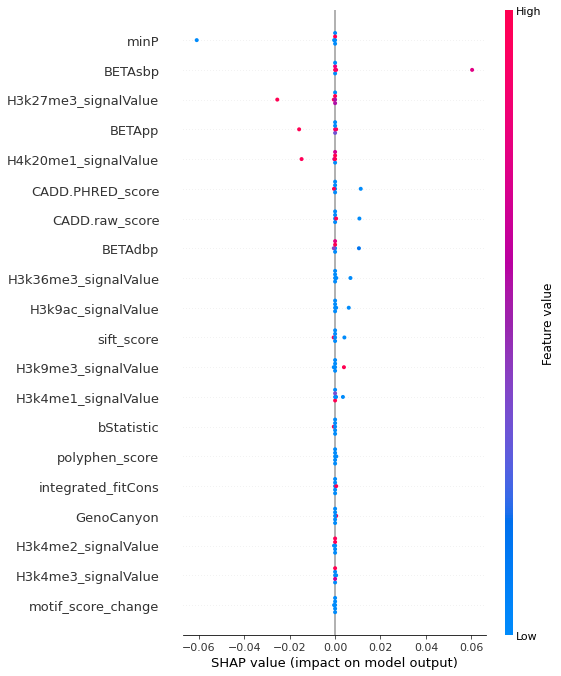

In [34]:
shap_values = ex.shap_values(y_pos_test)

fig, ax = plt.subplots()
shap.summary_plot(shap_values, y_pos_test)

In [35]:
expected_value = ex.expected_value

  0%|          | 0/6 [00:00<?, ?it/s]

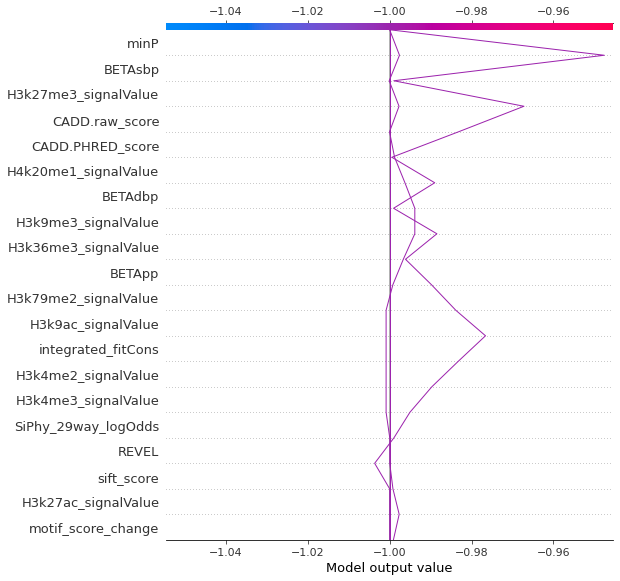

In [36]:
fig, ax = plt.subplots()
shap.decision_plot(
    expected_value,
    ex.shap_values(y_pos_test),
    list(y_pos_test),
    ignore_warnings=True,
)

## From Scratch Code Implementation:
### XGBoost:

In [73]:
X['Y'] = Y
data_P = X[X.Y == 1]
data_P_test = data_P.sample(frac=0.2)

df_both = data_P.append(data_P_test)
data_P = df_both.drop_duplicates(keep=False)

data_U = X[X.Y == 0]
data_U_test = data_U.sample(18)

df_both = data_U.append(data_U_test)
data_U = df_both.drop_duplicates(keep=False)

df_test = data_P_test.append(data_U_test)

data_P_train = data_P
data_P = data_P.drop(['Y'], axis=1)
data_U = data_U.drop(['Y'], axis=1)

NP = data_P.shape[0]
NU = data_U.shape[0]

In [54]:
iterations = 15
K = NP
train_label = np.zeros(shape=(NP+K,))
train_label[:NP] = 1.0
n_oob = np.zeros(shape=(NU,))
f_oob = np.zeros(shape=(NU, 2))
start = time.time()
for i in range(iterations):
    # Bootstrap resample
    bootstrap_sample = np.random.choice(np.arange(NU), replace=True, size=K)
    # Positive set + bootstrapped unlabeled set
    data_bootstrap = np.concatenate((data_P, data_U.iloc[bootstrap_sample, :]), axis=0)
    # Train model
    model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
    
    model.fit(data_bootstrap, train_label)
    # Index for the out of the bag (oob) samples
    idx_oob = sorted(set(range(NU)) - set(np.unique(bootstrap_sample)))
    # Transductive learning of oob samples
    f_oob[idx_oob] += model.predict_proba(data_U.iloc[idx_oob])
    n_oob[idx_oob] += 1
predict_proba = f_oob[:, 1]/n_oob

end = time.time()
print('Model fitting seconds:', (end - start))

Model fitting seconds: 0.790752649307251


In [72]:
data_P_test_true = data_P_test.drop(['Y'], axis=1)

y_pos = data_P_test['Y']
y_pos = list(y_pos)

y_pred_pos = model.predict_proba(data_P_test_true)
y_pred_pos = y_pred_pos[:,1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]


print('XGBoost Classification Results:')
acc = accuracy_score(y_pos, y_predict_pos)
print("Accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_pos, y_predict_pos)
print("F1 Score: %.2f%%" % (f1 * 100.0))

rec = recall_score(y_pos, y_predict_pos, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_pos, y_predict_pos, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

bal = balanced_accuracy_score(y_pos, y_predict_pos)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

XGBoost Classification Results:
Accuracy: 25.00%
F1 Score: 40.00%
recall: 25.00%
precision: 100.00%
balanaced accuracy: 25.00%


## Evaluating test set of both positives and negatives:

In [73]:
df_test_true = df_test.drop(['Y'], axis=1)

y_true = df_test['Y']

y_pred_pos = model.predict_proba(df_test_true)
y_pred_pos = y_pred_pos[:,1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]


print('XGBoost Classification Results:')
acc = accuracy_score(y_true, y_predict_pos)
print("Accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_true, y_predict_pos)
print("F1 Score: %.2f%%" % (f1 * 100.0))

rec = recall_score(y_true, y_predict_pos, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_true, y_predict_pos, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 


bal = balanced_accuracy_score(y_positive, y_predict)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

XGBoost Classification Results:
Accuracy: 31.82%
F1 Score: 11.76%
recall: 25.00%
precision: 7.69%
balanaced accuracy: 48.88%


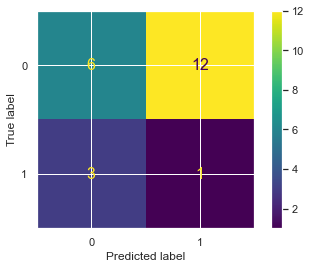

In [74]:
cm = confusion_matrix(y_true, y_predict_pos)

cm_display = ConfusionMatrixDisplay(cm).plot()

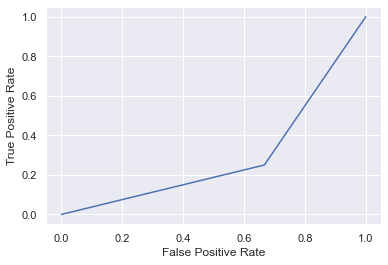

In [75]:
fpr, tpr, _ = roc_curve(y_true, y_predict_pos, pos_label=model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

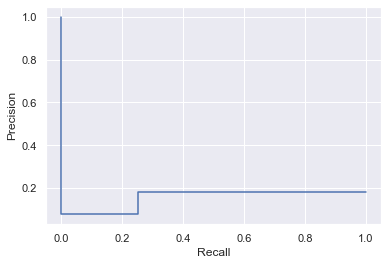

In [76]:
prec, recall, _ = precision_recall_curve(y_true, y_predict_pos, pos_label=model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

## SHAP view of positives only in test data:

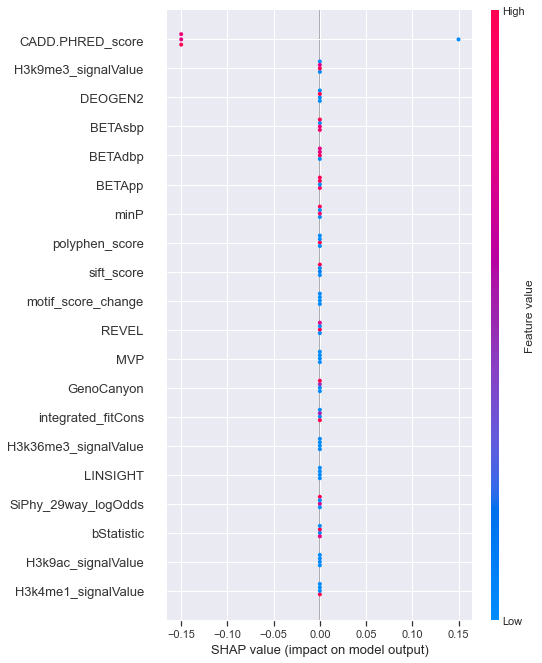

In [77]:
explainer = shap.TreeExplainer(model) 
shap_values = explainer.shap_values(data_P_test_true) 
shap.summary_plot(shap_values, data_P_test_true) 

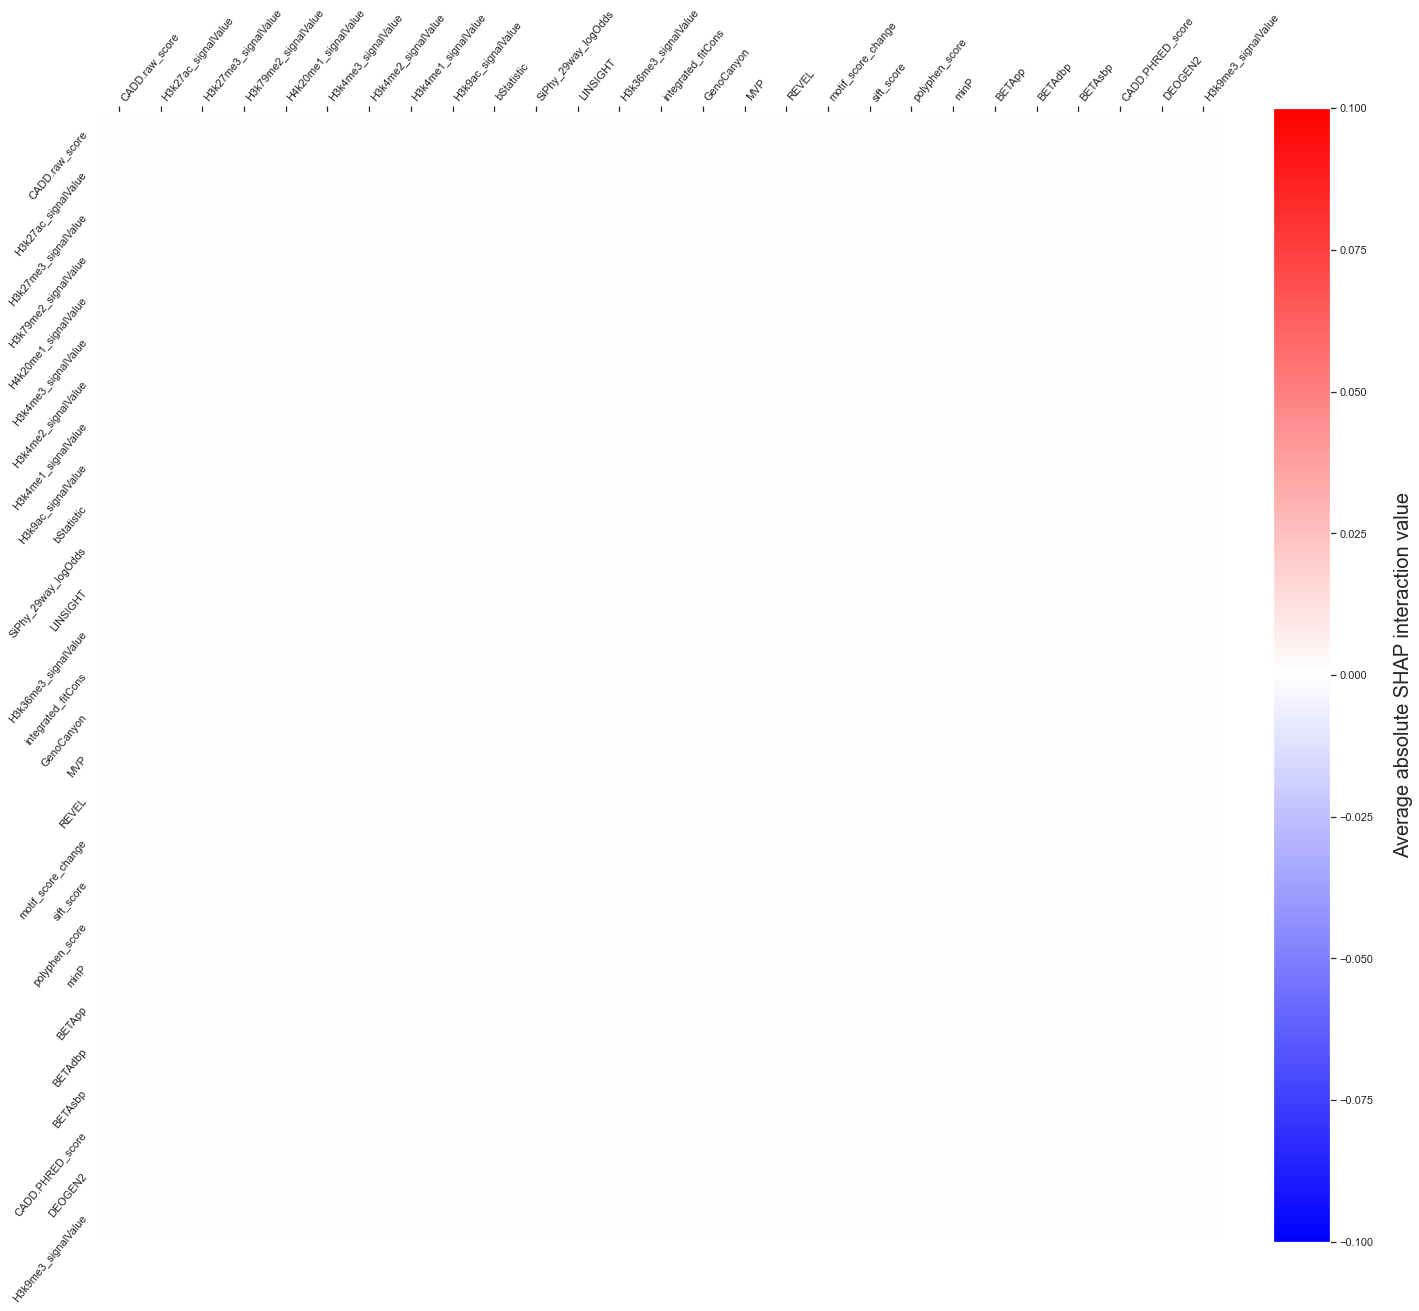

In [78]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(data_P_test_true)

expected_value = explainer.expected_value

tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i, i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds, :][:, inds]

sns.set(font_scale = 1)
f = plt.figure(figsize=(20, 20))
plt.imshow(
    tmp2, cmap="bwr"
)
plt.yticks(
    range(tmp2.shape[0]),
    data_P_test_true.columns[inds],
    rotation=50.4,
    horizontalalignment="right",
)
plt.xticks(
    range(tmp2.shape[0]),
    data_P_test_true.columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label("Average absolute SHAP interaction value", size=20, labelpad=20)
plt.rcParams.update({"font.size": 16})
plt.tight_layout()

In [79]:
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value

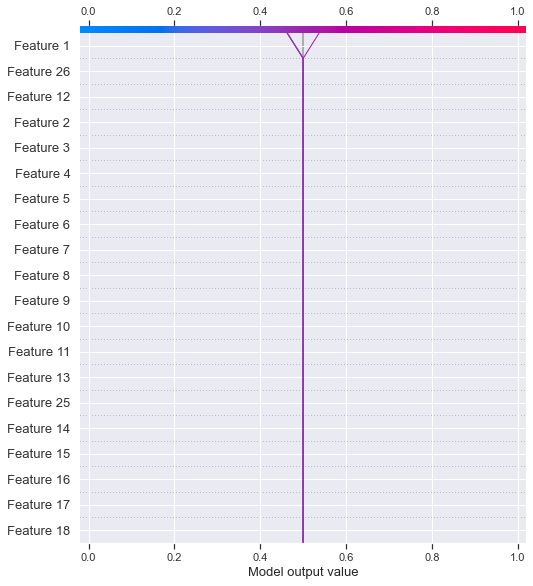

In [80]:
shap.decision_plot(expected_value, shap_values, link='logit')

In [29]:
X['Y'] = Y
data_P = X[X.Y == 1]
data_P_test = data_P.sample(frac=0.2)

df_both = data_P.append(data_P_test)
data_P = df_both.drop_duplicates(keep=False)

data_U = X[X.Y == 0]
data_U_test = data_U.sample(18)

df_both = data_U.append(data_U_test)
data_U = df_both.drop_duplicates(keep=False)

df_test = data_P_test.append(data_U_test)

data_P_train = data_P
data_P = data_P.drop(['Y'], axis=1)
data_U = data_U.drop(['Y'], axis=1)

NP = data_P.shape[0]
NU = data_U.shape[0]

In [30]:
T = 15
K = NP
train_label = np.zeros(shape=(NP+K,))
train_label[:NP] = 1.0
n_oob = np.zeros(shape=(NU,))
f_oob = np.zeros(shape=(NU, 2))
start = time.time()
for i in range(T):
    # Bootstrap resample
    bootstrap_sample = np.random.choice(np.arange(NU), replace=True, size=K)
    # Positive set + bootstrapped unlabeled set
    data_bootstrap = np.concatenate((data_P, data_U.iloc[bootstrap_sample, :]), axis=0)
    # Train model
    model = lgb.LGBMClassifier(random_state=seed, objective='binary')
    
    model.fit(data_bootstrap, train_label)
    # Index for the out of the bag (oob) samples
    idx_oob = sorted(set(range(NU)) - set(np.unique(bootstrap_sample)))
    # Transductive learning of oob samples
    f_oob[idx_oob] += model.predict_proba(data_U.iloc[idx_oob])
    n_oob[idx_oob] += 1
predict_proba = f_oob[:, 1]/n_oob

end = time.time()
print('Model fitting seconds:', (end - start))

Model fitting seconds: 0.89585280418396


In [31]:
data_P_test_true = data_P_test.drop(['Y'], axis=1)

y_pos = data_P_test['Y']
y_pos = list(y_pos)

y_pred_pos = model.predict_proba(data_P_test_true)
y_pred_pos = y_pred_pos[:,1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]


print('LightGBM Classification Results:')
acc = accuracy_score(y_pos, y_predict_pos)
print("Accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_pos, y_predict_pos)
print("F1 Score: %.2f%%" % (f1 * 100.0))

rec = recall_score(y_pos, y_predict_pos, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_pos, y_predict_pos, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

bal = balanced_accuracy_score(y_pos, y_predict_pos)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

LightGBM Classification Results:
Accuracy: 0.00%
F1 Score: 0.00%
recall: 0.00%
precision: 0.00%
balanaced accuracy: 0.00%


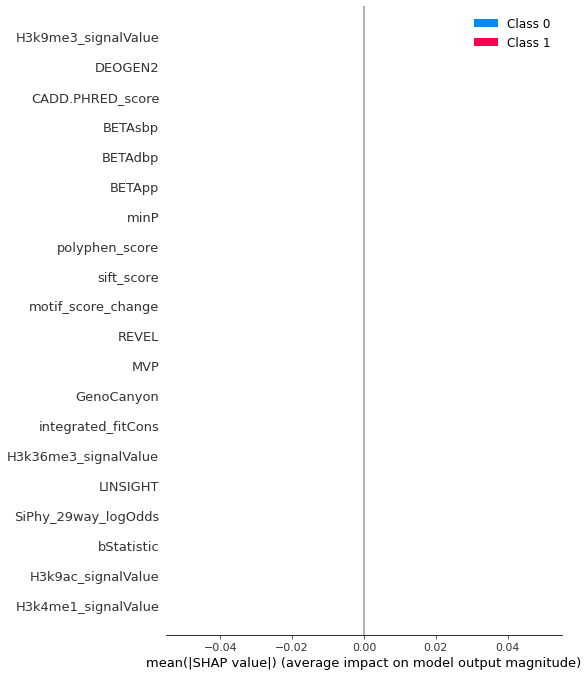

In [25]:
explainer = shap.TreeExplainer(model) 
shap_values = explainer.shap_values(data_P_test_true) 
shap.summary_plot(shap_values, data_P_test_true) 

In [85]:
df_test_true = df_test.drop(['Y'], axis=1)

y_true = df_test['Y']

y_pred_pos = model.predict_proba(df_test_true)
y_pred_pos = y_pred_pos[:,1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]


print('LightGBM Classification Results:')
acc = accuracy_score(y_true, y_predict_pos)
print("Accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_true, y_predict_pos)
print("F1 Score: %.2f%%" % (f1 * 100.0))
rec = recall_score(y_true, y_predict_pos, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_true, y_predict_pos, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 


bal = balanced_accuracy_score(y_true,y_predict_pos)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

LightGBM Classification Results:
Accuracy: 81.82%
F1 Score: 0.00%
recall: 0.00%
precision: 0.00%
balanaced accuracy: 50.00%


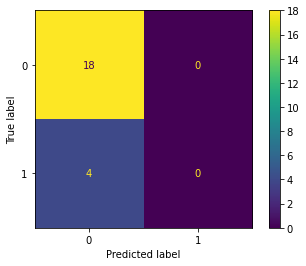

In [86]:
cm = confusion_matrix(y_true, y_predict_pos)

cm_display = ConfusionMatrixDisplay(cm).plot()

# 2. Using only <50% complete features

In [57]:
pd_table['Y'] = np.where(pd_table['label'] == True, 1, 0)
Y = pd_table['Y']
X = pd_table.drop(['label', 'Gene', 'CP', 'diagnosis', 'star', 'pathogenicity',
                   'Y'], axis=1)

X.drop(labels=correlated_features, axis=1, inplace=True)
imputer = SimpleImputer(strategy='median', missing_values=np.nan)
X = pd.DataFrame(imputer.fit_transform(X), index=X.index, columns=X.columns)

X = X[['BETAsbp',
 'BETAdbp',
 'minP',
    'DANN.score',
 'CADD.raw_score',
 'gerp_scores.N']]

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

### PULean Package with XGBoost:

In [59]:
model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
pu_estimator = BaggingPuClassifier(
    base_estimator=model, n_estimators=15)
pu_estimator.fit(X_train, y_train)

y_pred = pu_estimator.predict_proba(X_test)

In [60]:
y_pred = y_pred[:,1]
y_predict = [1 if x > 0.5 else 0 for x in y_pred]
y_positive = y_test == 1

print('Classification results:')
acc = accuracy_score(y_positive, y_predict)
print("accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_positive, y_predict)
print("f1: %.2f%%" % (f1 * 100.0)) 
roc = roc_auc_score(y_positive, y_predict)
print("roc: %.2f%%" % (roc * 100.0)) 
rec = recall_score(y_positive, y_predict, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_positive, y_predict, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

bal = balanced_accuracy_score(y_positive, y_predict)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

Classification results:
accuracy: 99.95%
f1: 25.00%
roc: 58.33%
recall: 16.67%
precision: 50.00%
balanaced accuracy: 58.33%


In [61]:
estimator = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
pu_estimator = ElkanotoPuClassifier(estimator, hold_out_ratio=0.2)
pu_estimator.fit(X_train.values, y_train.values)

y_pred = pu_estimator.predict_proba(X_test.values)

In [62]:
y_predict = [1 if x > 0.5 else 0 for x in y_pred]
y_positive = y_test == 1

print('Classification results:')
acc = accuracy_score(y_positive, y_predict)
print("accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_positive, y_predict)
print("f1: %.2f%%" % (f1 * 100.0)) 
roc = roc_auc_score(y_positive, y_predict)
print("roc: %.2f%%" % (roc * 100.0)) 
rec = recall_score(y_positive, y_predict, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_positive, y_predict, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

bal = balanced_accuracy_score(y_positive, y_predict)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

Classification results:
accuracy: 99.95%
f1: 25.00%
roc: 58.33%
recall: 16.67%
precision: 50.00%
balanaced accuracy: 58.33%


In [63]:
model = lgb.LGBMClassifier(random_state=seed)
pu_estimator = BaggingPuClassifier(
    base_estimator=model, n_estimators=15)
pu_estimator.fit(X_train, y_train)

y_pred = pu_estimator.predict_proba(X_test)

In [64]:
y_pred = y_pred[:,1]
y_predict = [1 if x > 0.5 else 0 for x in y_pred]
y_positive = y_test == 1

print('Classification results:')
acc = accuracy_score(y_positive, y_predict)
print("accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_positive, y_predict)
print("f1: %.2f%%" % (f1 * 100.0)) 
roc = roc_auc_score(y_positive, y_predict)
print("roc: %.2f%%" % (roc * 100.0)) 
rec = recall_score(y_positive, y_predict, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_positive, y_predict, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

bal = balanced_accuracy_score(y_positive, y_predict)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

Classification results:
accuracy: 99.95%
f1: 0.00%
roc: 50.00%
recall: 0.00%
precision: 0.00%
balanaced accuracy: 50.00%


In [65]:
estimator = lgb.LGBMClassifier(random_state=seed)
pu_estimator = ElkanotoPuClassifier(estimator, hold_out_ratio=0.2)
pu_estimator.fit(X_train.values, y_train.values)

y_pred = pu_estimator.predict_proba(X_test.values)

In [66]:
y_predict = [1 if x > 0.5 else 0 for x in y_pred]
y_positive = y_test == 1

print('Classification results:')
acc = accuracy_score(y_positive, y_predict)
print("accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_positive, y_predict)
print("f1: %.2f%%" % (f1 * 100.0)) 
roc = roc_auc_score(y_positive, y_predict)
print("roc: %.2f%%" % (roc * 100.0)) 
rec = recall_score(y_positive, y_predict, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_positive, y_predict, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

bal = balanced_accuracy_score(y_positive, y_predict)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

Classification results:
accuracy: 28.10%
f1: 0.02%
roc: 22.39%
recall: 16.67%
precision: 0.01%
balanaced accuracy: 22.39%


In [67]:
X['Y'] = Y
data_P = X[X.Y == 1]
data_P_test = data_P.sample(frac=0.2)

df_both = data_P.append(data_P_test)
data_P = df_both.drop_duplicates(keep=False)

data_U = X[X.Y == 0]
data_U_test = data_U.sample(207)

df_both = data_U.append(data_U_test)
data_U = df_both.drop_duplicates(keep=False)

df_test = data_P_test.append(data_U_test)

data_P_train = data_P
data_P = data_P.drop(['Y'], axis=1)
data_U = data_U.drop(['Y'], axis=1)

NP = data_P.shape[0]
NU = data_U.shape[0]

iterations = 15
K = NP
train_label = np.zeros(shape=(NP+K,))
train_label[:NP] = 1.0
n_oob = np.zeros(shape=(NU,))
f_oob = np.zeros(shape=(NU, 2))
start = time.time()
for i in range(iterations):
    # Bootstrap resample
    bootstrap_sample = np.random.choice(np.arange(NU), replace=True, size=K)
    # Positive set + bootstrapped unlabeled set
    data_bootstrap = np.concatenate((data_P, data_U.iloc[bootstrap_sample, :]), axis=0)
    # Train model
    model = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
    
    model.fit(data_bootstrap, train_label)
    # Index for the out of the bag (oob) samples
    idx_oob = sorted(set(range(NU)) - set(np.unique(bootstrap_sample)))
    # Transductive learning of oob samples
    f_oob[idx_oob] += model.predict_proba(data_U.iloc[idx_oob])
    n_oob[idx_oob] += 1
predict_proba = f_oob[:, 1]/n_oob

end = time.time()
print('Model fitting seconds:', (end - start))

Model fitting seconds: 2.8965299129486084


In [68]:
data_P_test_true = data_P_test.drop(['Y'], axis=1)

y_pos = data_P_test['Y']
y_pos = list(y_pos)

y_pred_pos = model.predict_proba(data_P_test_true)
y_pred_pos = y_pred_pos[:,1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]


print('XGBoost Classification Results:')
acc = accuracy_score(y_pos, y_predict_pos)
print("Accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_pos, y_predict_pos)
print("F1 Score: %.2f%%" % (f1 * 100.0))

rec = recall_score(y_pos, y_predict_pos, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_pos, y_predict_pos, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

bal = balanced_accuracy_score(y_pos, y_predict_pos)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

XGBoost Classification Results:
Accuracy: 50.00%
F1 Score: 66.67%
recall: 50.00%
precision: 100.00%
balanaced accuracy: 50.00%


In [69]:
iterations = 15
K = NP
train_label = np.zeros(shape=(NP+K,))
train_label[:NP] = 1.0
n_oob = np.zeros(shape=(NU,))
f_oob = np.zeros(shape=(NU, 2))
start = time.time()
for i in range(iterations):
    # Bootstrap resample
    bootstrap_sample = np.random.choice(np.arange(NU), replace=True, size=K)
    # Positive set + bootstrapped unlabeled set
    data_bootstrap = np.concatenate((data_P, data_U.iloc[bootstrap_sample, :]), axis=0)
    # Train model
    model = lgb.LGBMClassifier(random_state=seed)
    
    model.fit(data_bootstrap, train_label)
    # Index for the out of the bag (oob) samples
    idx_oob = sorted(set(range(NU)) - set(np.unique(bootstrap_sample)))
    # Transductive learning of oob samples
    f_oob[idx_oob] += model.predict_proba(data_U.iloc[idx_oob])
    n_oob[idx_oob] += 1
predict_proba = f_oob[:, 1]/n_oob

end = time.time()
print('Model fitting seconds:', (end - start))

data_P_test_true = data_P_test.drop(['Y'], axis=1)

y_pos = data_P_test['Y']
y_pos = list(y_pos)

y_pred_pos = model.predict_proba(data_P_test_true)
y_pred_pos = y_pred_pos[:,1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]


print('LightGBM Classification Results:')
acc = accuracy_score(y_pos, y_predict_pos)
print("Accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_pos, y_predict_pos)
print("F1 Score: %.2f%%" % (f1 * 100.0))

rec = recall_score(y_pos, y_predict_pos, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_pos, y_predict_pos, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

bal = balanced_accuracy_score(y_pos, y_predict_pos)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

Model fitting seconds: 1.1334431171417236
LightGBM Classification Results:
Accuracy: 0.00%
F1 Score: 0.00%
recall: 0.00%
precision: 0.00%
balanaced accuracy: 0.00%


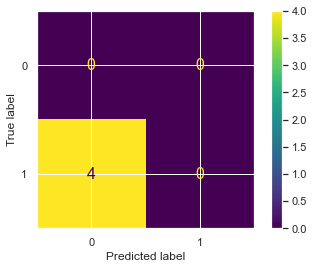

In [70]:
cm = confusion_matrix(y_pos, y_predict_pos)

cm_display = ConfusionMatrixDisplay(cm).plot()

# 3. XGBoost with missing values:

In [71]:
pd_table = pd.read_csv('BP_GWAS_data.csv')

In [72]:
cols = ['H3k9ac_signalValue',
 'H3k4me1_signalValue',
 'H3k4me2_signalValue',
 'H3k4me3_signalValue',
 'H4k20me1_signalValue',
 'H3k79me2_signalValue',
 'H3k27me3_signalValue',
 'H3k27ac_signalValue',
 'H3k36me3_signalValue',
 'H3k9me3_signalValue',
       'motif_impact',
 'intergenic_impact',
 'regulatory_impact',
 'transcript_impact',
 'lof_HC',
 'polyphen_pred',
 'sift_pred',
 'polyphen_score',
 'sift_score',
 'motif_score_change',
 'GTEx_mean_proportion',
 'REVEL',
 'MVP',
 'GenoCanyon',
 'DEOGEN2',
 'integrated_fitCons',
 'LINSIGHT',
 'SiPhy_29way_logOdds',
 'bStatistic',]
pd_table[cols] = pd_table[cols].replace(0, np.nan)

In [73]:
pd_table['Y'] = np.where(pd_table['label'] == True, 1, 0)
Y = pd_table['Y']
X = pd_table.drop(['label', 'Gene', 'CP', 'diagnosis', 'star', 'pathogenicity',
                   'Y'], axis=1)

X.drop(labels=correlated_features, axis=1, inplace=True)

In [74]:
X['Y'] = Y
data_P = X[X.Y == 1]
data_P_test = data_P.sample(frac=0.2)

df_both = data_P.append(data_P_test)
data_P = df_both.drop_duplicates(keep=False)

data_U = X[X.Y == 0]
data_U_test = data_U.sample(207)

df_both = data_U.append(data_U_test)
data_U = df_both.drop_duplicates(keep=False)

df_test = data_P_test.append(data_U_test)

data_P_train = data_P
data_P = data_P.drop(['Y'], axis=1)
data_U = data_U.drop(['Y'], axis=1)

NP = data_P.shape[0]
NU = data_U.shape[0]

In [75]:
T = 15
K = NP
train_label = np.zeros(shape=(NP+K,))
train_label[:NP] = 1.0
n_oob = np.zeros(shape=(NU,))
f_oob = np.zeros(shape=(NU, 2))
start = time.time()
for i in range(T):
    # Bootstrap resample
    bootstrap_sample = np.random.choice(np.arange(NU), replace=True, size=K)
    # Positive set + bootstrapped unlabeled set
    data_bootstrap = np.concatenate((data_P, data_U.iloc[bootstrap_sample, :]), axis=0)
    # Train model
    model = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
    
    model.fit(data_bootstrap, train_label)
    # Index for the out of the bag (oob) samples
    idx_oob = sorted(set(range(NU)) - set(np.unique(bootstrap_sample)))
    # Transductive learning of oob samples
    f_oob[idx_oob] += model.predict_proba(data_U.iloc[idx_oob])
    n_oob[idx_oob] += 1
predict_proba = f_oob[:, 1]/n_oob

end = time.time()
print('Model fitting seconds:', (end - start))

Model fitting seconds: 3.266566038131714


In [76]:
data_P_test_true = data_P_test.drop(['Y'], axis=1)

y_pos = data_P_test['Y']
y_pos = list(y_pos)

y_pred_pos = model.predict_proba(data_P_test_true)
y_pred_pos = y_pred_pos[:,1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]


print('XGBoost Classification Results:')
acc = accuracy_score(y_pos, y_predict_pos)
print("Accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_pos, y_predict_pos)
print("F1 Score: %.2f%%" % (f1 * 100.0))

rec = recall_score(y_pos, y_predict_pos, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_pos, y_predict_pos, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

bal = balanced_accuracy_score(y_pos, y_predict_pos)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

XGBoost Classification Results:
Accuracy: 0.00%
F1 Score: 0.00%
recall: 0.00%
precision: 0.00%
balanaced accuracy: 0.00%


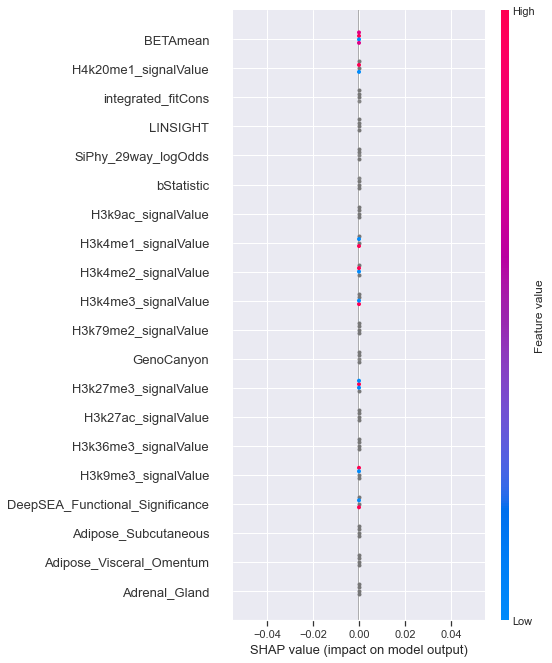

In [77]:
explainer = shap.TreeExplainer(model) 
shap_values = explainer.shap_values(data_P_test_true) 
shap.summary_plot(shap_values, data_P_test_true) 

In [78]:
T = 15
K = NP
train_label = np.zeros(shape=(NP+K,))
train_label[:NP] = 1.0
n_oob = np.zeros(shape=(NU,))
f_oob = np.zeros(shape=(NU, 2))
start = time.time()
for i in range(T):
    # Bootstrap resample
    bootstrap_sample = np.random.choice(np.arange(NU), replace=True, size=K)
    # Positive set + bootstrapped unlabeled set
    data_bootstrap = np.concatenate((data_P, data_U.iloc[bootstrap_sample, :]), axis=0)
    # Train model
    model =  lgb.LGBMClassifier(random_state=seed)
    
    model.fit(data_bootstrap, train_label)
    # Index for the out of the bag (oob) samples
    idx_oob = sorted(set(range(NU)) - set(np.unique(bootstrap_sample)))
    # Transductive learning of oob samples
    f_oob[idx_oob] += model.predict_proba(data_U.iloc[idx_oob])
    n_oob[idx_oob] += 1
predict_proba = f_oob[:, 1]/n_oob

end = time.time()
print('Model fitting seconds:', (end - start))

Model fitting seconds: 1.5678069591522217


In [79]:
data_P_test_true = data_P_test.drop(['Y'], axis=1)

y_pos = data_P_test['Y']
y_pos = list(y_pos)

y_pred_pos = model.predict_proba(data_P_test_true)
y_pred_pos = y_pred_pos[:,1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]


print('LightGBM Classification Results:')
acc = accuracy_score(y_pos, y_predict_pos)
print("Accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_pos, y_predict_pos)
print("F1 Score: %.2f%%" % (f1 * 100.0))

rec = recall_score(y_pos, y_predict_pos, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_pos, y_predict_pos, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

bal = balanced_accuracy_score(y_pos, y_predict_pos)
print("balanaced accuracy: %.2f%%" % (bal * 100.0))

LightGBM Classification Results:
Accuracy: 0.00%
F1 Score: 0.00%
recall: 0.00%
precision: 0.00%
balanaced accuracy: 0.00%


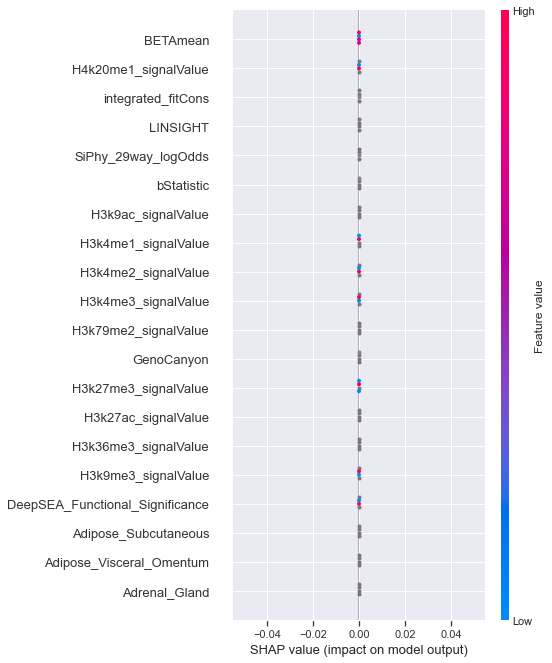

In [80]:
explainer = shap.TreeExplainer(model) 
shap_values = explainer.shap_values(data_P_test_true) 
shap.summary_plot(shap_values[0], data_P_test_true) 

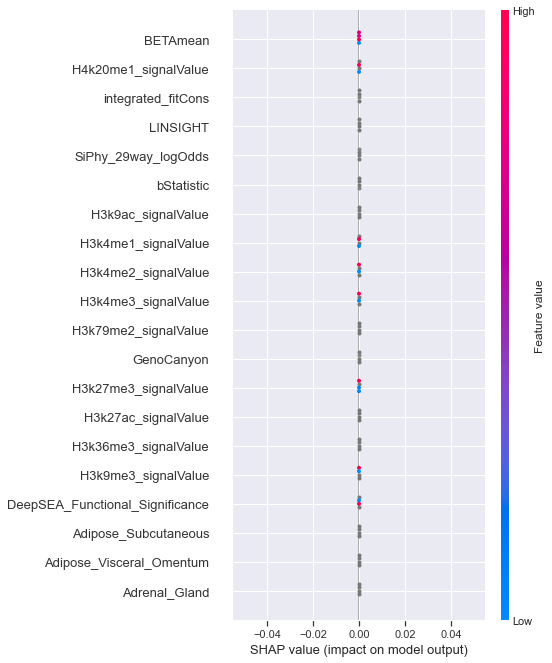

In [81]:
explainer = shap.TreeExplainer(model) 
shap_values = explainer.shap_values(data_P_test_true) 
shap.summary_plot(shap_values[1], data_P_test_true) 